### Operating Discriminator on Embedding Space instead of image space

Checking if GAN works fine if discriminator is made to differenciate on embedding space rather than image space. The embedding function $\phi$ is fixed with random weights.

<img src = 'images/emGAN.png' width=500 height=500/>

where **generator G** is fully convolutional as follows :-

<img src = 'images/emGAN_G.png' width=300 height=300/>

and **discriminator D** is densely connected as follows :-

<img src = 'images/emGAN_E.png' width=300 height=300/>

The **embedding network E** contains two convolutional layers initialized with random weights which are fixed. So, we can say that the embedding network is a fixed mapping from the output space of the generator to the input space of discriminator :- 

<img src = 'images/emGAN_D.png' width=300 height=300/>


#### Some common functions

In [2]:
import numpy as np

import torch
from torch.autograd import Variable

import torch.nn as nn

# import activation functions
import torch.nn.functional as F

# import optimization functions
import torch.optim as optim

# torch vision functions
import torchvision


# add the loadDataset function [required as an interface to custom dataloaders]
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset, getChannels
reload(sys.modules[loadDataset.__module__])


import matplotlib
import matplotlib.pyplot as plt

import time

In [3]:
def showTrainHist(trainHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(trainHist['discLoss']))

    y1 = trainHist['discLoss']
    y2 = trainHist['genLoss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

In [4]:
batchSize = 256

numNoiseChannels = 100
numGenFilter = 64
numDiscFilter = 64

learningRate = 0.0002
epochs = 100

cuda = 1

imageSize = 32
numClasses = 10

In [5]:
modelFolder = 'dummy'

GInitF = 'G_init.pt'
DInitF = 'D_init.pt'
EInitF = 'E_init.pt'

GFinalF = 'G_fin.pt'
DFinalF = 'D_fin.pt'
EFinalF = 'E_fin.pt'


def change():
    
    GInit = Generator(numNoiseChannels, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GInitF
    GInit.load_state_dict(torch.load(PATH))

    DInit = Discriminator()
    PATH = modelFolder + '/' + DInitF
    DInit.load_state_dict(torch.load(PATH))

    EInit = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EInitF
    EInit.load_state_dict(torch.load(PATH))
    
    
    GFin = Generator(numNoiseChannels, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GFinalF
    GFin.load_state_dict(torch.load(PATH))

    DFin = Discriminator()
    PATH = modelFolder + '/' + DFinalF
    DFin.load_state_dict(torch.load(PATH))

    EFin = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EFinalF
    EFin.load_state_dict(torch.load(PATH))
    
    GFlag = True    
    DFlag = True
    EFlag = True
    
    for m in GFin._modules:   
        if isinstance(GFin._modules[m], nn.ConvTranspose2d) or isinstance(GFin._modules[m],nn.BatchNorm2d):
            GFlag = GFlag and (GFin._modules[m].weight == GInit._modules[m].weight).data.all()
    

    for m in DFin._modules:
        if isinstance(DFin._modules[m], nn.Linear) or isinstance(DFin._modules[m],nn.BatchNorm2d):
            DFlag = DFlag and (DFin._modules[m].weight == DInit._modules[m].weight).data.all()
    
    
    for m in EFin._modules:
        
        if isinstance(EFin._modules[m], nn.Conv2d) or isinstance(EFin._modules[m],nn.BatchNorm2d):
            EFlag = EFlag and (EFin._modules[m].weight == EInit._modules[m].weight).data.all()

    if GFlag:
        print 'Generator: Weights are same'
    else:
        print 'Generator: Weights are different'
        
    if DFlag:
        print 'Discriminator: Weights are same'
    else:
        print 'Discriminator: Weights are different'

    if EFlag:
        print 'Embedding: Weights are same'
    else:
        print 'Embedding: Weights are different'

def change_C():
    
    GInit = Generator(numNoiseChannels, numClasses, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GInitF
    GInit.load_state_dict(torch.load(PATH))

    DInit = Discriminator(numClasses)
    PATH = modelFolder + '/' + DInitF
    DInit.load_state_dict(torch.load(PATH))

    EInit = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EInitF
    EInit.load_state_dict(torch.load(PATH))
    
    
    GFin = Generator(numNoiseChannels, numClasses, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GFinalF
    GFin.load_state_dict(torch.load(PATH))

    DFin = Discriminator(numClasses)
    PATH = modelFolder + '/' + DFinalF
    DFin.load_state_dict(torch.load(PATH))

    EFin = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EFinalF
    EFin.load_state_dict(torch.load(PATH))
    
    GFlag = True    
    DFlag = True
    EFlag = True
    
    for m in GFin._modules:   
        if isinstance(GFin._modules[m], nn.ConvTranspose2d) or isinstance(GFin._modules[m],nn.BatchNorm2d):
            GFlag = GFlag and (GFin._modules[m].weight == GInit._modules[m].weight).data.all()
    

    for m in DFin._modules:
        if isinstance(DFin._modules[m], nn.Linear) or isinstance(DFin._modules[m],nn.BatchNorm2d):
            DFlag = DFlag and (DFin._modules[m].weight == DInit._modules[m].weight).data.all()
    
    
    for m in EFin._modules:
        if isinstance(EFin._modules[m], nn.Conv2d) or isinstance(EFin._modules[m],nn.BatchNorm2d):
            EFlag = EFlag and (EFin._modules[m].weight == EInit._modules[m].weight).data.all()

    if GFlag:
        print 'Generator: Weights are same'
    else:
        print 'Generator: Weights are different'
        
    if DFlag:
        print 'Discriminator: Weights are same'
    else:
        print 'Discriminator: Weights are different'

    if EFlag:
        print 'Embedding: Weights are same'
    else:
        print 'Embedding: Weights are different'

This notebook contains of the below four experiments :-

- A randomly initialized embedding layer *E* with DC-GAN
    - MNIST
    - SVHN
- A triplet loss initalized embedding layer *E* with DC-GAN
    - MNIST ( $\boldsymbol{\theta}$ from the trained network )
    - SVHN  ($\boldsymbol{\phi}$ from the trained network)
- A randomly initialized embedding layer *E* with cDC-GAN
    - MNIST
    - SVHN
- A triplet loss initialized embedding layer *E* with cDC-GAN
    - MNIST ($\boldsymbol{\theta}$ from the trained network)
    - SVHN  ($\boldsymbol{\phi}$ from the trained network)

### Training function for DC-GAN 

In [6]:
def train(primaryTrainLoader,
          embeddingNetwork,
          learningRate = 0.0002,
          epochs = 5,
          embeddingNetWt=0):
    
    G = Generator(numNoiseChannels, numGenFilter, numPrimaryOutputChannels)
    D = Discriminator()
    E = embeddingNetwork
    
    #initialize the weights here
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    
    if embeddingNetWt==1:
        E = embeddingNetwork(numPrimaryOutputChannels)
        E.weight_init(mean=0.0, std=0.02)
    
    PATH = modelFolder+'/' + GInitF
    torch.save(G.state_dict(), PATH)
    PATH = modelFolder+'/' + DInitF
    torch.save(D.state_dict(), PATH)
    PATH = modelFolder+'/' + EInitF
    torch.save(E.state_dict(), PATH)
    
    
    # setting the require_grad as False for all parameters pertaining thera and phi
    for param in E.parameters():
        param.require_grad=False
    
    
    # take the binary cross entropy loss 
    lossFunction = nn.BCELoss()
    
    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator
    discRealInput = torch.FloatTensor(batchSize,
                                      numPrimaryOutputChannels,
                                      imageSize,
                                      imageSize)
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numNoiseChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    # to check the formation of image, we define a fixed noise vector
    fixedNoise = torch.FloatTensor(batchSize,
                                   numNoiseChannels,
                                   1,
                                   1)
    fixedNoise.normal_(0,1)
    

    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        E = E.cuda()
        
        lossFunction = lossFunction.cuda()
        
        discRealInput = discRealInput.cuda()
        discRealLabel = discRealLabel.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        
    fixedNoiseV = Variable(fixedNoise)
    
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # training starts   
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        epochStartTime = time.time()
        
        
        for i,data in enumerate(primaryTrainLoader, 0):
            
            # train discriminator D
            
            # set the gradients in computation graph of discriminator to be 0
            D.zero_grad()
            dataInstance, dataLabel = data
            if cuda:
                dataInstance = dataInstance.cuda()
            
            #print discRealInput.shape, dataInstance.shape
            # train discriminator on real classes
            discRealInput.copy_(dataInstance)
            
            discRealInputV = Variable(discRealInput)
            discRealLabelV = Variable(discRealLabel)
            
            discRealInputEmbedding = E(discRealInputV)
            
            #print discRealInputV.data.shape, discRealInputEmbedding.data.shape

            #print discRealInput.shape
            discRealOutput = D(discRealInputEmbedding)
            
            
            discLossReal = lossFunction(discRealOutput,
                                        discRealLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossReal.backward()
            
            # train discriminator on fake classes
            discFakeInput.normal_(0,1)
            discFakeInputV = Variable(discFakeInput)
            discFakeLabelV = Variable(discFakeLabel)
            
            genFakeOutput = G(discFakeInputV)
            
            genFakeOutputEmbedding = E(genFakeOutput)
            
            # detach the graph prior to D. So what weights in G do not get updated
            discFakeOutput = D(genFakeOutputEmbedding.detach())
            
            discLossFake = lossFunction(discFakeOutput,
                                        discFakeLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossFake.backward()
            
            # log the loss for discriminator
            discriminatorLosses.append((discLossReal+discLossFake).data[0])
            
            # update the weights
            discOptimizer.step()
            
            # train generator with discriminator feedback
            G.zero_grad()
            
            discFakeOutput = D(genFakeOutputEmbedding)
            genLossFake = lossFunction(discFakeOutput, discRealLabelV)
            
            genLossFake.backward()
            genOptimizer.step()
            
            # log the loss for generator
            generatorLosses.append(genLossFake.data[0])
                            
        epochEndTime = time.time()
        perEpochTime = epochEndTime - epochStartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        
    # create an image for every epoch
    # generate samples from trained generator
    genImage = G(fixedNoiseV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    
    showTrainHist(trainHist)
    
    PATH = modelFolder+'/' + GFinalF
    torch.save(G.state_dict(), PATH)
    PATH = modelFolder+'/' + DFinalF
    torch.save(D.state_dict(), PATH)
    PATH = modelFolder+'/' + EFinalF
    torch.save(E.state_dict(), PATH)

### Training function for conditional DC-GAN 

In [7]:
# train using the primary class only 

def train_C(primaryTrainLoader,
          embeddingNetwork,
          learningRate = 0.0002,
          epochs=20,
          embeddingNetWt=0):
    
    G = Generator(numNoiseChannels, numClasses, numGenFilter, numPrimaryOutputChannels)
    E = embeddingNetwork
    D = Discriminator(numClasses)

    #initialize weights 
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    
    
    if embeddingNetWt==1:
        E = embeddingNetwork(numPrimaryOutputChannels)
        E.weight_init(mean=0.0, std=0.02)
    # setting the require_grad as False for all parameters pertaining thera and phi
    for param in E.parameters():
        param.require_grad=False
        
    PATH = modelFolder+'/' + GInitF
    torch.save(G.state_dict(), PATH)
    PATH = modelFolder+'/' + DInitF
    torch.save(D.state_dict(), PATH)
    PATH = modelFolder+'/' + EInitF
    torch.save(E.state_dict(), PATH)

    # define loss function and optimizers
    lossFunction = nn.BCELoss()

    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator pertaining primary class
    discRealInputPrimary = torch.FloatTensor(batchSize,
                                      numPrimaryOutputChannels,
                                      imageSize,
                                      imageSize)
    
    
    # label is 1 for real examples and 0 for generated examples
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numNoiseChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    discRealInputClass = torch.zeros(batchSize,
                                     numClasses)
    
    discFakeInputClass = torch.zeros( batchSize,
                                      numClasses,
                                      1,
                                      1)    
    
    

    # to check the formation of image, we define a fixed noise vector
    numElementsNeededPerClass = 10
    
    fixedNoise = torch.randn(numElementsNeededPerClass*numClasses,
                             numNoiseChannels,
                             1,
                             1)
    
    # class from which the GAN should output a distribution
    fixedNoiseClass = torch.zeros(numElementsNeededPerClass*numClasses,
                                  numClasses,
                                  1,
                                  1)
    
    classIndex = torch.zeros(numElementsNeededPerClass,1)
    for i in range(numClasses-1):
        temp = torch.ones(numElementsNeededPerClass,1)+i
        classIndex = torch.cat([classIndex, temp], 0)
    
    fixedNoiseClass = fixedNoiseClass.squeeze().scatter_(1, classIndex.type(torch.LongTensor), 1)
    fixedNoiseClass = fixedNoiseClass.view(-1,
                                           numClasses,
                                           1,
                                           1)
    
    
    # can take the oneHot representation to feed into generator and discriminator directly from here
    oneHotGen = torch.zeros(numClasses, numClasses)
    oneHotGen = oneHotGen.scatter_(1, torch.LongTensor([i for i in range(numClasses)]).view(numClasses,1), 1).view(numClasses, numClasses, 1, 1)
    oneHotDisc = oneHotGen.squeeze()
      
    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        E = E.cuda()
        
        lossFunction = lossFunction.cuda()
        
        discRealInputPrimary = discRealInputPrimary.cuda()
        
        discRealLabel = discRealLabel.cuda()
        
        discRealInputClass = discRealInputClass.cuda()
        discFakeInputClass = discFakeInputClass.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        fixedNoiseClass = fixedNoiseClass.cuda()
        
        
        
    fixedNoiseV = Variable(fixedNoise)
    
    fixedNoiseClassV = Variable(fixedNoiseClass)

    # loggers
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # train using theta - the embedding of primary class only
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        primaryEpochstartTime = time.time()
        
        for i,data in enumerate(primaryTrainLoader, 0):

            # train discriminator D

            # set the gradients in computation graph of discriminator to be 0
            D.zero_grad()
            dataInstance, dataClass = data

            # one-hot encoding for discriminator class input
            dataClassOH = oneHotDisc[dataClass]

            if cuda:
                dataClass = dataClass.cuda()
                dataInstance = dataInstance.cuda()
                dataClassOH = dataClassOH.cuda()


            #print discRealInputPrimary.shape, dataInstance.shape

            # train discriminator on real classes
            discRealInputPrimary.copy_(dataInstance)
            discRealInputClass.copy_(dataClassOH)

            discRealInputPrimaryV = Variable(discRealInputPrimary)
            discRealInputClassV = Variable(discRealInputClass)
            discRealLabelV = Variable(discRealLabel)
            dataClassV = Variable(dataClass)

            ## given embedding of the real data instead of image to disceriminator
            ## returns a pytorch Variable batchSize x 84 ie theta for particular batch
            #print discRealInputV
            discRealInputEmbedding = E(discRealInputPrimaryV)
            
            #print discRealInputEmbedding.data.shape, discRealInputClassV.data.shape
            #print discRealInputEmbedding.data.shape, discRealInputClassV.data.shape
            discRealOutput = D(discRealInputEmbedding,
                               discRealInputClassV)

        
            discLossReal = lossFunction(discRealOutput,
                                        discRealLabelV)

            # calculate the gradients for nodes of computation graph
            discLossReal.backward()

            # train discriminator on fake classes
            #  p=getProbDist(primaryInstanceList)
            dataFakeClass = torch.from_numpy(np.random.choice(numClasses, batchSize))
            discFakeInputClass = oneHotDisc[dataFakeClass]
            genFakeInputClass = oneHotGen[dataFakeClass]
            

            if cuda:
                dataFakeClass = dataFakeClass.cuda()
                discFakeInputClass = discFakeInputClass.cuda()
                genFakeInputClass = genFakeInputClass.cuda()


            discFakeInput.normal_(0,1)
            
            dataFakeClassV = Variable(dataFakeClass)
            discFakeInputClassV= Variable(discFakeInputClass)
            genFakeInputClassV = Variable(genFakeInputClass)
            
            discFakeInputV = Variable(discFakeInput)
            discFakeLabelV = Variable(discFakeLabel)

            genFakeOutput = G(discFakeInputV,
                              genFakeInputClassV)
            #genFakeOutput = genFakeOutput.view(batchSize,-1)

            # get the 84 dimensional embedding of generator output
            genFakeOutputEmbedding = E(genFakeOutput)

            # detach the graph prior to D. So what weights in G do not get updated
            #print genFakeOutput.data.shape, discFakeInputClassV.data.shape
            
            #print genFakeOutputEmbedding.data.shape, discFakeInputClassV.data.shape

            discFakeOutput = D(genFakeOutputEmbedding.detach(),
                               discFakeInputClassV)

            discLossFake = lossFunction(discFakeOutput,
                                        discFakeLabelV)

            # calculate the gradients for nodes of computation graph
            discLossFake.backward()

            # log the loss for discriminator
            discriminatorLosses.append((discLossReal+discLossFake).data[0])

            # update the weights
            discOptimizer.step()

            # train generator with discriminator feedback
            G.zero_grad()


            # have to freeze weights of theta
            discFakeOutput = D(genFakeOutputEmbedding,
                               discFakeInputClassV)

            genLossFake = lossFunction(discFakeOutput, 
                                       discRealLabelV)

            genLossFake.backward()
            genOptimizer.step()

            # log the loss for generator
            generatorLosses.append(genLossFake.data[0])



        epochEndTime = time.time()
        perEpochTime = epochEndTime - primaryEpochstartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        
    # create an image for every epoch
    # generate samples from trained generator
    
    
    genImage = G(fixedNoiseV,
                 fixedNoiseClassV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    
    showTrainHist(trainHist)
    
    PATH = modelFolder+'/' + GFinalF
    torch.save(G.state_dict(), PATH)
    PATH = modelFolder+'/' + DFinalF
    torch.save(D.state_dict(), PATH)
    PATH = modelFolder+'/' + EFinalF
    torch.save(E.state_dict(), PATH)

### A randomly initialized embedding layer *E* with DC-GAN

In [18]:
from model_exp0 import Generator, Discriminator, EmbeddingNet

#### MNIST dataset

In [19]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

In [20]:
embeddingNet = EmbeddingNet

#### Training for 5 epochs

Epoch : [1/5] time: 7.97, loss_d: 1.336, loss_g: 0.679
Epoch : [2/5] time: 7.85, loss_d: 1.277, loss_g: 0.749
Epoch : [3/5] time: 8.33, loss_d: 1.257, loss_g: 0.795
Epoch : [4/5] time: 7.87, loss_d: 1.228, loss_g: 0.838
Epoch : [5/5] time: 7.85, loss_d: 1.200, loss_g: 0.885


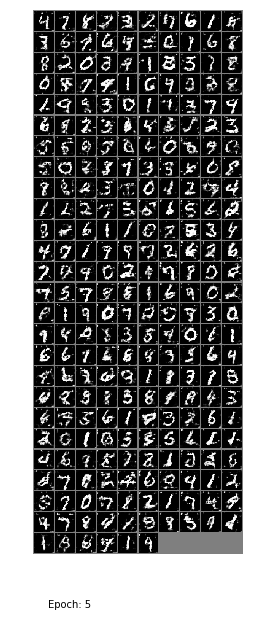

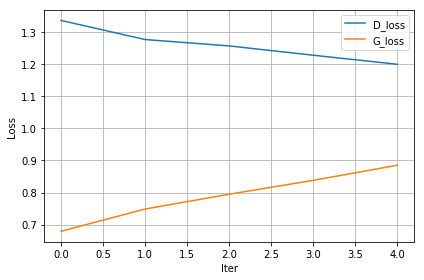

In [21]:
train(primaryTrainLoader, embeddingNet, epochs=5, embeddingNetWt=1)

In [22]:
change()

Generator: Weights are different
Discriminator: Weights are different
Embedding: Weights are same


#### Now running the same experiment for 30 epochs 

Epoch : [1/30] time: 7.81, loss_d: 1.317, loss_g: 0.732
Epoch : [2/30] time: 7.69, loss_d: 1.260, loss_g: 0.766
Epoch : [3/30] time: 7.70, loss_d: 1.217, loss_g: 0.822
Epoch : [4/30] time: 7.71, loss_d: 1.175, loss_g: 0.881
Epoch : [5/30] time: 7.71, loss_d: 1.147, loss_g: 0.935
Epoch : [6/30] time: 7.80, loss_d: 1.128, loss_g: 0.982
Epoch : [7/30] time: 7.90, loss_d: 1.125, loss_g: 1.012
Epoch : [8/30] time: 7.90, loss_d: 1.121, loss_g: 1.044
Epoch : [9/30] time: 8.30, loss_d: 1.120, loss_g: 1.064
Epoch : [10/30] time: 7.87, loss_d: 1.111, loss_g: 1.093
Epoch : [11/30] time: 7.85, loss_d: 1.114, loss_g: 1.113
Epoch : [12/30] time: 7.87, loss_d: 1.109, loss_g: 1.117
Epoch : [13/30] time: 7.84, loss_d: 1.117, loss_g: 1.133
Epoch : [14/30] time: 7.87, loss_d: 1.108, loss_g: 1.142
Epoch : [15/30] time: 7.86, loss_d: 1.116, loss_g: 1.154
Epoch : [16/30] time: 7.84, loss_d: 1.125, loss_g: 1.148
Epoch : [17/30] time: 7.84, loss_d: 1.128, loss_g: 1.148
Epoch : [18/30] time: 7.87, loss_d: 1.13

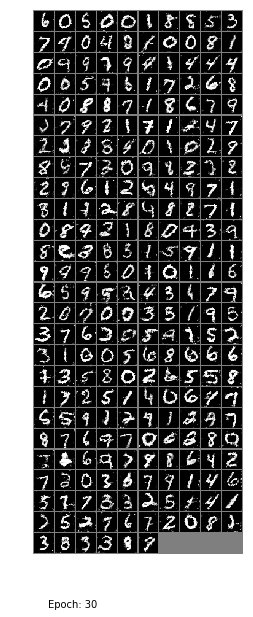

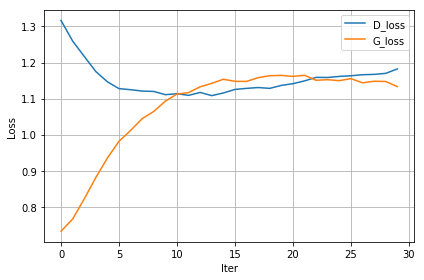

In [ ]:
train(primaryTrainLoader, embeddingNet, epochs=30, embeddingNetWt=1)

Epoch : [1/100] time: 8.18, loss_d: 1.350, loss_g: 0.667
Epoch : [2/100] time: 8.02, loss_d: 1.307, loss_g: 0.736
Epoch : [3/100] time: 8.00, loss_d: 1.270, loss_g: 0.785
Epoch : [4/100] time: 8.03, loss_d: 1.241, loss_g: 0.830
Epoch : [5/100] time: 8.00, loss_d: 1.218, loss_g: 0.868
Epoch : [6/100] time: 8.02, loss_d: 1.204, loss_g: 0.900
Epoch : [7/100] time: 8.03, loss_d: 1.202, loss_g: 0.925
Epoch : [8/100] time: 7.99, loss_d: 1.199, loss_g: 0.942
Epoch : [9/100] time: 8.00, loss_d: 1.200, loss_g: 0.962
Epoch : [10/100] time: 8.54, loss_d: 1.198, loss_g: 0.970
Epoch : [11/100] time: 8.00, loss_d: 1.193, loss_g: 0.981
Epoch : [12/100] time: 8.03, loss_d: 1.194, loss_g: 0.994
Epoch : [13/100] time: 8.03, loss_d: 1.193, loss_g: 1.003
Epoch : [14/100] time: 8.01, loss_d: 1.200, loss_g: 1.005
Epoch : [15/100] time: 8.03, loss_d: 1.198, loss_g: 1.005
Epoch : [16/100] time: 8.21, loss_d: 1.205, loss_g: 1.008
Epoch : [17/100] time: 7.99, loss_d: 1.205, loss_g: 1.016
Epoch : [18/100] time: 

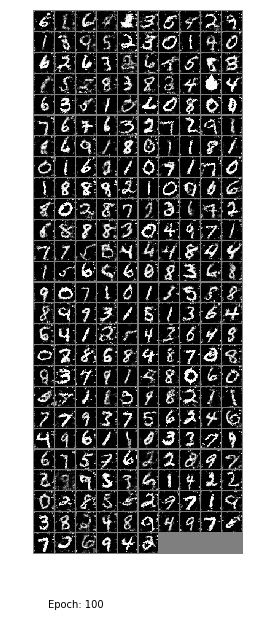

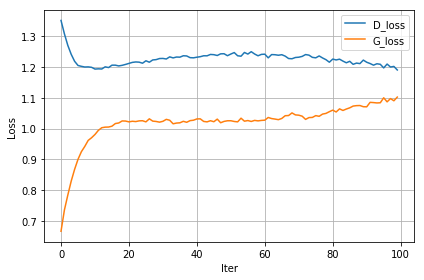

In [10]:
train(primaryTrainLoader, embeddingNet, epochs=100, embeddingNetWt=1)

#### SVHN 

In [25]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'SVHN'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

Epoch : [1/5] time: 9.63, loss_d: 1.374, loss_g: 0.710
Epoch : [2/5] time: 9.47, loss_d: 1.383, loss_g: 0.697
Epoch : [3/5] time: 9.49, loss_d: 1.383, loss_g: 0.696
Epoch : [4/5] time: 9.48, loss_d: 1.384, loss_g: 0.696
Epoch : [5/5] time: 9.93, loss_d: 1.385, loss_g: 0.697


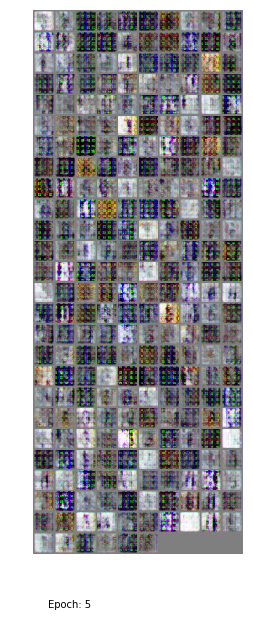

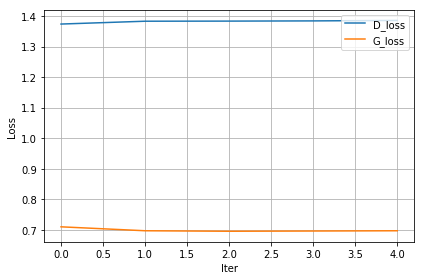

In [26]:
train(primaryTrainLoader, embeddingNet, epochs=5, embeddingNetWt=1)

Epoch : [1/30] time: 9.81, loss_d: 1.325, loss_g: 0.689
Epoch : [2/30] time: 9.61, loss_d: 1.353, loss_g: 0.705
Epoch : [3/30] time: 9.58, loss_d: 1.380, loss_g: 0.706
Epoch : [4/30] time: 9.58, loss_d: 1.382, loss_g: 0.704
Epoch : [5/30] time: 9.56, loss_d: 1.382, loss_g: 0.702
Epoch : [6/30] time: 9.61, loss_d: 1.382, loss_g: 0.704
Epoch : [7/30] time: 9.59, loss_d: 1.381, loss_g: 0.704
Epoch : [8/30] time: 9.59, loss_d: 1.380, loss_g: 0.705
Epoch : [9/30] time: 10.03, loss_d: 1.379, loss_g: 0.706
Epoch : [10/30] time: 9.76, loss_d: 1.378, loss_g: 0.707
Epoch : [11/30] time: 9.69, loss_d: 1.378, loss_g: 0.708
Epoch : [12/30] time: 9.73, loss_d: 1.376, loss_g: 0.710
Epoch : [13/30] time: 9.72, loss_d: 1.376, loss_g: 0.711
Epoch : [14/30] time: 9.72, loss_d: 1.376, loss_g: 0.710
Epoch : [15/30] time: 9.74, loss_d: 1.374, loss_g: 0.712
Epoch : [16/30] time: 9.74, loss_d: 1.376, loss_g: 0.712
Epoch : [17/30] time: 10.03, loss_d: 1.374, loss_g: 0.713
Epoch : [18/30] time: 9.71, loss_d: 1.

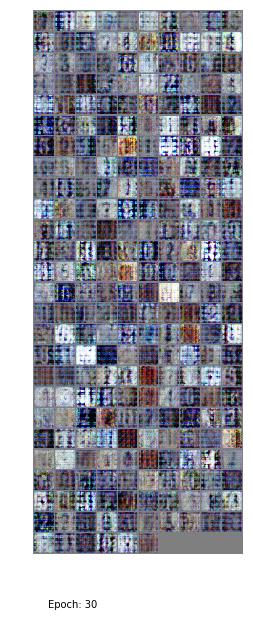

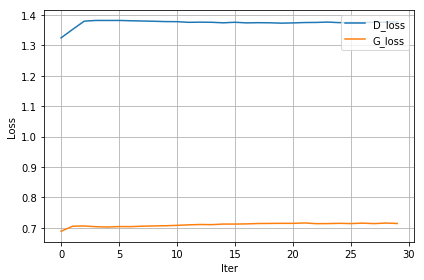

In [27]:
train(primaryTrainLoader, embeddingNet, epochs=30, embeddingNetWt=1)

Epoch : [1/100] time: 9.75, loss_d: 1.339, loss_g: 0.720
Epoch : [2/100] time: 9.74, loss_d: 1.373, loss_g: 0.707
Epoch : [3/100] time: 10.08, loss_d: 1.381, loss_g: 0.703
Epoch : [4/100] time: 9.71, loss_d: 1.382, loss_g: 0.701
Epoch : [5/100] time: 9.69, loss_d: 1.382, loss_g: 0.701
Epoch : [6/100] time: 9.74, loss_d: 1.381, loss_g: 0.703
Epoch : [7/100] time: 9.76, loss_d: 1.378, loss_g: 0.703
Epoch : [8/100] time: 9.75, loss_d: 1.377, loss_g: 0.707
Epoch : [9/100] time: 9.68, loss_d: 1.375, loss_g: 0.709
Epoch : [10/100] time: 9.73, loss_d: 1.374, loss_g: 0.711
Epoch : [11/100] time: 9.71, loss_d: 1.374, loss_g: 0.711
Epoch : [12/100] time: 9.74, loss_d: 1.374, loss_g: 0.713
Epoch : [13/100] time: 9.72, loss_d: 1.376, loss_g: 0.712
Epoch : [14/100] time: 9.73, loss_d: 1.376, loss_g: 0.713
Epoch : [15/100] time: 9.71, loss_d: 1.376, loss_g: 0.713
Epoch : [16/100] time: 10.09, loss_d: 1.376, loss_g: 0.714
Epoch : [17/100] time: 9.70, loss_d: 1.377, loss_g: 0.712
Epoch : [18/100] time

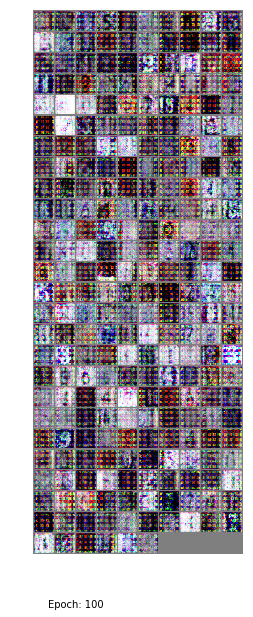

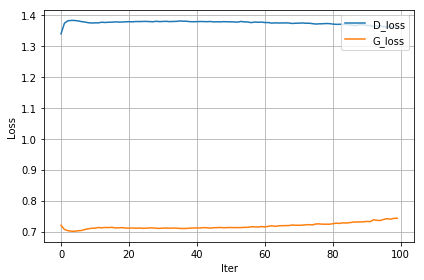

In [28]:
train(primaryTrainLoader, embeddingNet, epochs=100, embeddingNetWt=1)

## Triplet Loss intialised embedding layer E with DCGAN 

#### MNIST Dataset

In [25]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

In [26]:
# we will now be using LeNet instead of embeddingNet
from networks import LeNet, TripletNet

# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
helperDataset = 'SVHN'
numClasses = 10
cuda = 1

# theta and phi are defined based on the number of channels in primary and helper datasets
theta = LeNet(getChannels(primaryDataset))
phi = LeNet(getChannels(helperDataset))

# load the weights of neural networks $\theta$ and $\phi$ saved while training using Siamese and Triplet loss
model = TripletNet(theta, phi)

if cuda:
    model = model.cuda()

modelFoldername = 'models'
modelFileName = primaryDataset+'_'+helperDataset+'_'+'triplet'+'.pt'

PATH = modelFoldername + '/' + modelFileName
model.load_state_dict(torch.load(PATH))

# setting the require_grad as False for all parameters pertaining thera and phi
for param in model.parameters():
    param.require_grad=False

In [27]:
embeddingNet = model.embedding_net_1

#### Function to train the GAN with a trained triplet embedding E

/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch : [1/5] time: 10.95, loss_d: 1.303, loss_g: 0.730
Epoch : [2/5] time: 7.79, loss_d: 1.054, loss_g: 0.899
Epoch : [3/5] time: 7.91, loss_d: 0.775, loss_g: 1.182
Epoch : [4/5] time: 7.82, loss_d: 0.593, loss_g: 1.425
Epoch : [5/5] time: 7.85, loss_d: 0.482, loss_g: 1.672


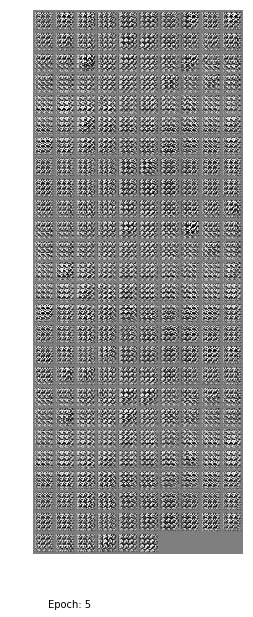

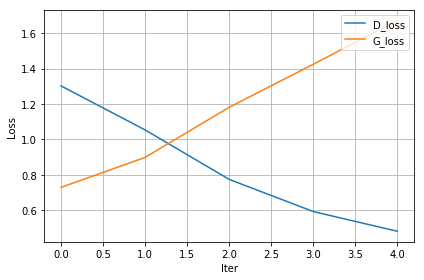

In [11]:
train(primaryTrainLoader, embeddingNet, epochs=5, embeddingNetWt=0)

In [23]:
change()

Generator: Weights are different
Discriminator: Weights are different
Embedding: Weights are same


Epoch : [1/30] time: 8.42, loss_d: 1.283, loss_g: 0.741
Epoch : [2/30] time: 7.89, loss_d: 1.035, loss_g: 0.904
Epoch : [3/30] time: 7.90, loss_d: 0.779, loss_g: 1.158
Epoch : [4/30] time: 8.18, loss_d: 0.534, loss_g: 1.532
Epoch : [5/30] time: 8.38, loss_d: 0.457, loss_g: 1.646
Epoch : [6/30] time: 8.18, loss_d: 0.561, loss_g: 1.436
Epoch : [7/30] time: 8.14, loss_d: 0.545, loss_g: 1.244
Epoch : [8/30] time: 8.03, loss_d: 0.352, loss_g: 1.647
Epoch : [9/30] time: 8.02, loss_d: 0.241, loss_g: 2.003
Epoch : [10/30] time: 8.01, loss_d: 0.174, loss_g: 2.307
Epoch : [11/30] time: 7.96, loss_d: 0.133, loss_g: 2.567
Epoch : [12/30] time: 8.00, loss_d: 0.102, loss_g: 2.813
Epoch : [13/30] time: 8.00, loss_d: 0.081, loss_g: 3.046
Epoch : [14/30] time: 7.97, loss_d: 0.066, loss_g: 3.263
Epoch : [15/30] time: 7.99, loss_d: 0.054, loss_g: 3.468
Epoch : [16/30] time: 8.97, loss_d: 0.205, loss_g: 3.097
Epoch : [17/30] time: 8.01, loss_d: 0.321, loss_g: 2.081
Epoch : [18/30] time: 8.05, loss_d: 0.23

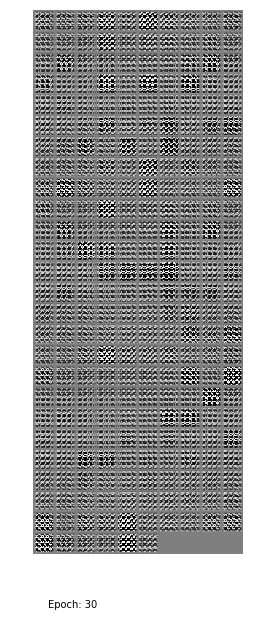

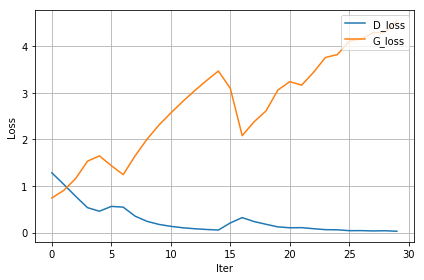

In [28]:
train(primaryTrainLoader, embeddingNet, epochs=30, embeddingNetWt=0)

#### SVHN Dataset

#### Function to train the GAN with a trained triplet embedding E

In [30]:
embeddingNet = model.embedding_net_2

In [31]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'SVHN'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

Epoch : [1/5] time: 9.77, loss_d: 1.300, loss_g: 0.743
Epoch : [2/5] time: 9.62, loss_d: 1.018, loss_g: 0.925
Epoch : [3/5] time: 9.61, loss_d: 0.746, loss_g: 1.190
Epoch : [4/5] time: 9.63, loss_d: 0.603, loss_g: 1.408
Epoch : [5/5] time: 9.66, loss_d: 0.462, loss_g: 1.656


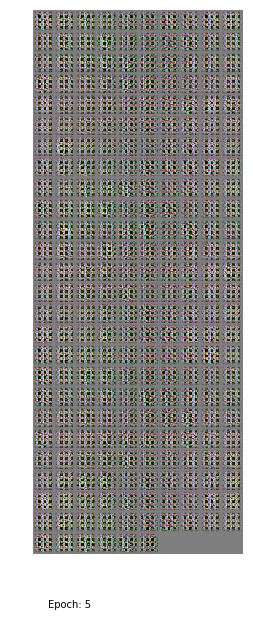

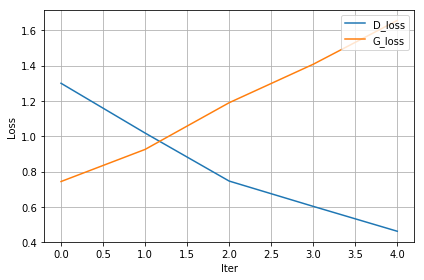

In [32]:
train(primaryTrainLoader, embeddingNet, epochs=5, embeddingNetWt=0)

Epoch : [1/30] time: 9.93, loss_d: 1.293, loss_g: 0.741
Epoch : [2/30] time: 9.94, loss_d: 1.029, loss_g: 0.923
Epoch : [3/30] time: 10.27, loss_d: 0.748, loss_g: 1.226
Epoch : [4/30] time: 9.91, loss_d: 0.631, loss_g: 1.375
Epoch : [5/30] time: 9.83, loss_d: 0.832, loss_g: 0.855
Epoch : [6/30] time: 9.84, loss_d: 0.583, loss_g: 1.164
Epoch : [7/30] time: 9.83, loss_d: 0.416, loss_g: 1.462
Epoch : [8/30] time: 9.82, loss_d: 0.305, loss_g: 1.738
Epoch : [9/30] time: 9.77, loss_d: 0.238, loss_g: 1.977
Epoch : [10/30] time: 9.80, loss_d: 0.177, loss_g: 2.222
Epoch : [11/30] time: 9.79, loss_d: 0.260, loss_g: 2.182
Epoch : [12/30] time: 9.85, loss_d: 0.449, loss_g: 1.751
Epoch : [13/30] time: 9.84, loss_d: 0.320, loss_g: 2.119
Epoch : [14/30] time: 9.86, loss_d: 0.255, loss_g: 2.424
Epoch : [15/30] time: 10.18, loss_d: 0.199, loss_g: 2.544
Epoch : [16/30] time: 9.84, loss_d: 0.173, loss_g: 2.686
Epoch : [17/30] time: 9.82, loss_d: 0.137, loss_g: 2.934
Epoch : [18/30] time: 9.86, loss_d: 0.

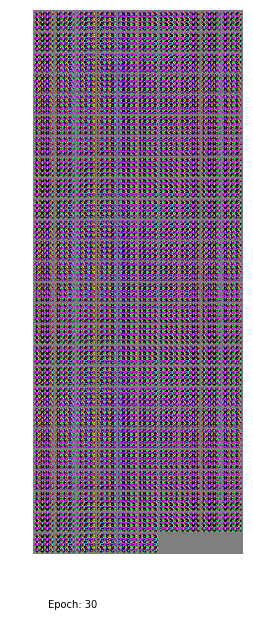

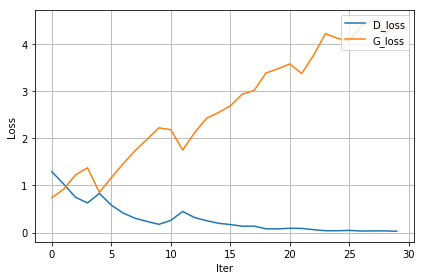

In [33]:
train(primaryTrainLoader, embeddingNet, epochs=30, embeddingNetWt=0)

### Now using the conditional GAN for experiments

#### Randomly initialized embedding layer

In [8]:
from model_exp0a_c import Generator, Discriminator, EmbeddingNet

In [9]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

In [10]:
numClasses = 10
embeddingNet = EmbeddingNet

Epoch : [1/30] time: 8.22, loss_d: 1.373, loss_g: 0.701
Epoch : [2/30] time: 8.06, loss_d: 1.378, loss_g: 0.702
Epoch : [3/30] time: 8.06, loss_d: 1.377, loss_g: 0.701
Epoch : [4/30] time: 8.07, loss_d: 1.373, loss_g: 0.702
Epoch : [5/30] time: 8.09, loss_d: 1.372, loss_g: 0.704
Epoch : [6/30] time: 8.06, loss_d: 1.363, loss_g: 0.709
Epoch : [7/30] time: 8.07, loss_d: 1.358, loss_g: 0.712
Epoch : [8/30] time: 8.19, loss_d: 1.351, loss_g: 0.721
Epoch : [9/30] time: 8.28, loss_d: 1.345, loss_g: 0.723
Epoch : [10/30] time: 8.30, loss_d: 1.355, loss_g: 0.718
Epoch : [11/30] time: 8.63, loss_d: 1.338, loss_g: 0.729
Epoch : [12/30] time: 8.21, loss_d: 1.321, loss_g: 0.748
Epoch : [13/30] time: 8.24, loss_d: 1.323, loss_g: 0.755
Epoch : [14/30] time: 8.25, loss_d: 1.323, loss_g: 0.749
Epoch : [15/30] time: 8.27, loss_d: 1.315, loss_g: 0.753
Epoch : [16/30] time: 8.22, loss_d: 1.311, loss_g: 0.766
Epoch : [17/30] time: 8.25, loss_d: 1.309, loss_g: 0.763
Epoch : [18/30] time: 8.27, loss_d: 1.29

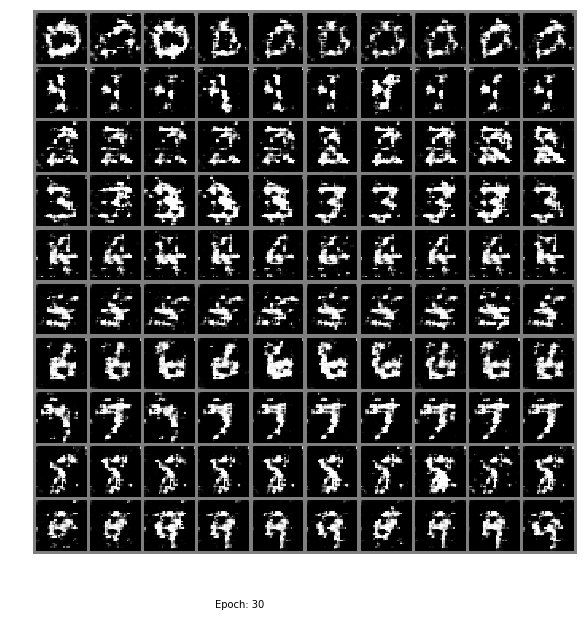

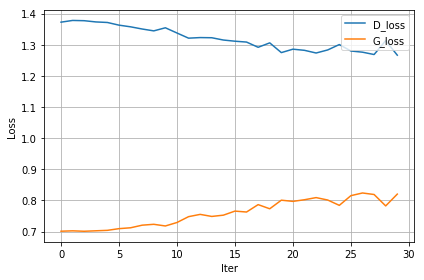

In [37]:
train_C(primaryTrainLoader, embeddingNet, epochs=30, embeddingNetWt=1)

/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch : [1/100] time: 11.91, loss_d: 1.374, loss_g: 0.706
Epoch : [2/100] time: 7.99, loss_d: 1.379, loss_g: 0.701
Epoch : [3/100] time: 7.98, loss_d: 1.378, loss_g: 0.701
Epoch : [4/100] time: 8.02, loss_d: 1.373, loss_g: 0.702
Epoch : [5/100] time: 8.03, loss_d: 1.366, loss_g: 0.708
Epoch : [6/100] time: 8.60, loss_d: 1.364, loss_g: 0.709
Epoch : [7/100] time: 8.26, loss_d: 1.358, loss_g: 0.713
Epoch : [8/100] time: 8.27, loss_d: 1.351, loss_g: 0.719
Epoch : [9/100] time: 8.26, loss_d: 1.353, loss_g: 0.720
Epoch : [10/100] time: 8.21, loss_d: 1.338, loss_g: 0.735
Epoch : [11/100] time: 8.19, loss_d: 1.323, loss_g: 0.746
Epoch : [12/100] time: 8.19, loss_d: 1.329, loss_g: 0.746
Epoch : [13/100] time: 8.19, loss_d: 1.326, loss_g: 0.747
Epoch : [14/100] time: 8.21, loss_d: 1.323, loss_g: 0.755
Epoch : [15/100] time: 8.19, loss_d: 1.336, loss_g: 0.741
Epoch : [16/100] time: 8.19, loss_d: 1.315, loss_g: 0.762
Epoch : [17/100] time: 8.19, loss_d: 1.309, loss_g: 0.771
Epoch : [18/100] time:

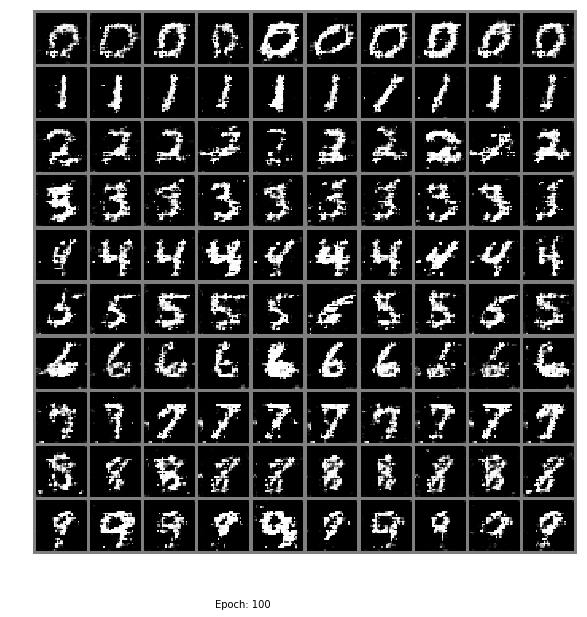

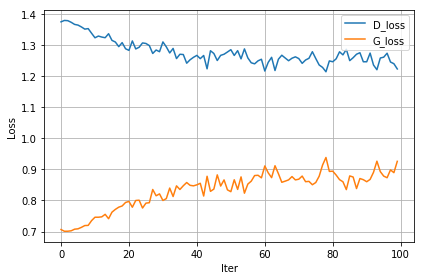

In [11]:
train_C(primaryTrainLoader, embeddingNet, epochs=100, embeddingNetWt=1)

In [13]:
change_C()

Generator: Weights are different
Discriminator: Weights are different
Embedding: Weights are same


### SVHN Data

In [16]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'SVHN'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primayTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primayTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

Epoch : [1/30] time: 8.34, loss_d: 1.372, loss_g: 0.693
Epoch : [2/30] time: 8.18, loss_d: 1.381, loss_g: 0.699
Epoch : [3/30] time: 8.20, loss_d: 1.383, loss_g: 0.698
Epoch : [4/30] time: 8.17, loss_d: 1.380, loss_g: 0.698
Epoch : [5/30] time: 8.22, loss_d: 1.377, loss_g: 0.700
Epoch : [6/30] time: 8.20, loss_d: 1.372, loss_g: 0.704
Epoch : [7/30] time: 8.26, loss_d: 1.371, loss_g: 0.704
Epoch : [8/30] time: 8.22, loss_d: 1.361, loss_g: 0.711
Epoch : [9/30] time: 8.23, loss_d: 1.356, loss_g: 0.715
Epoch : [10/30] time: 8.29, loss_d: 1.346, loss_g: 0.723
Epoch : [11/30] time: 8.83, loss_d: 1.344, loss_g: 0.729
Epoch : [12/30] time: 8.39, loss_d: 1.333, loss_g: 0.741
Epoch : [13/30] time: 8.41, loss_d: 1.323, loss_g: 0.749
Epoch : [14/30] time: 8.38, loss_d: 1.319, loss_g: 0.759
Epoch : [15/30] time: 8.42, loss_d: 1.317, loss_g: 0.757
Epoch : [16/30] time: 8.42, loss_d: 1.314, loss_g: 0.767
Epoch : [17/30] time: 8.42, loss_d: 1.296, loss_g: 0.780
Epoch : [18/30] time: 8.44, loss_d: 1.29

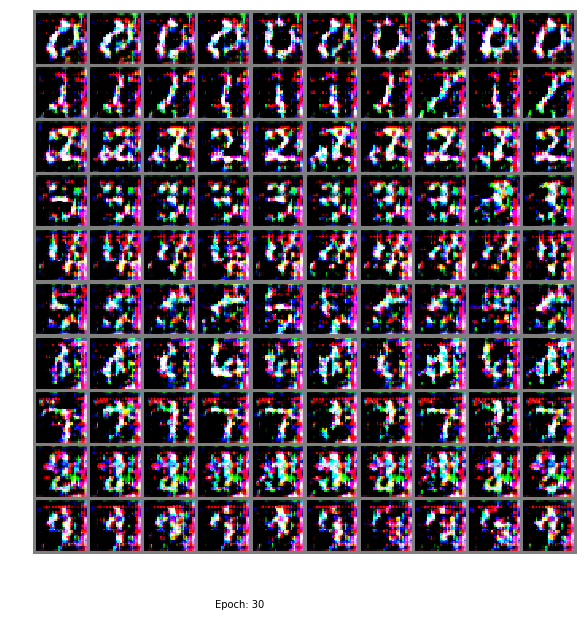

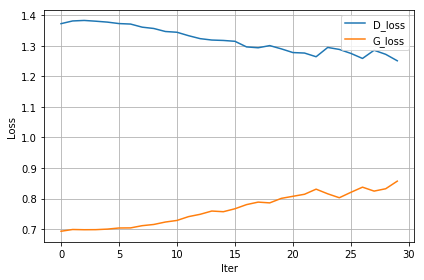

In [17]:
train_C(primaryTrainLoader, embeddingNet, epochs=30, embeddingNetWt=1)

Epoch : [1/100] time: 8.45, loss_d: 1.373, loss_g: 0.691
Epoch : [2/100] time: 8.57, loss_d: 1.380, loss_g: 0.699
Epoch : [3/100] time: 8.54, loss_d: 1.382, loss_g: 0.697
Epoch : [4/100] time: 8.48, loss_d: 1.380, loss_g: 0.698
Epoch : [5/100] time: 8.80, loss_d: 1.374, loss_g: 0.701
Epoch : [6/100] time: 8.50, loss_d: 1.368, loss_g: 0.704
Epoch : [7/100] time: 8.76, loss_d: 1.361, loss_g: 0.709
Epoch : [8/100] time: 8.45, loss_d: 1.354, loss_g: 0.716
Epoch : [9/100] time: 8.79, loss_d: 1.349, loss_g: 0.720
Epoch : [10/100] time: 8.42, loss_d: 1.348, loss_g: 0.722
Epoch : [11/100] time: 8.45, loss_d: 1.355, loss_g: 0.720
Epoch : [12/100] time: 8.47, loss_d: 1.337, loss_g: 0.733
Epoch : [13/100] time: 8.49, loss_d: 1.331, loss_g: 0.737
Epoch : [14/100] time: 8.67, loss_d: 1.320, loss_g: 0.751
Epoch : [15/100] time: 8.48, loss_d: 1.321, loss_g: 0.750
Epoch : [16/100] time: 8.40, loss_d: 1.310, loss_g: 0.768
Epoch : [17/100] time: 8.45, loss_d: 1.309, loss_g: 0.767
Epoch : [18/100] time: 

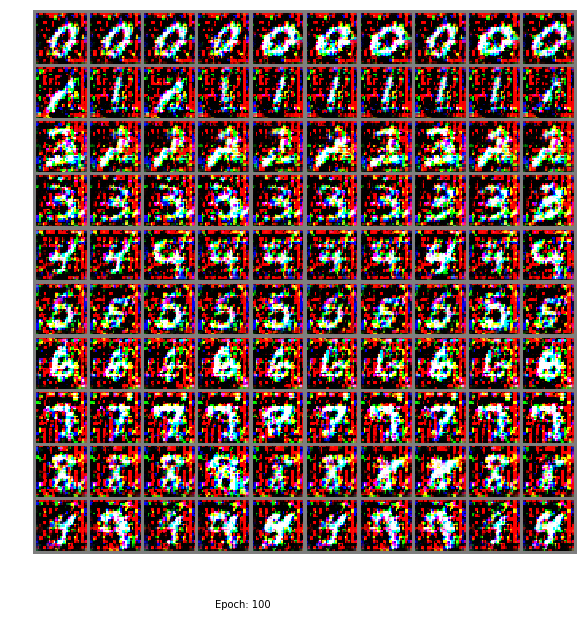

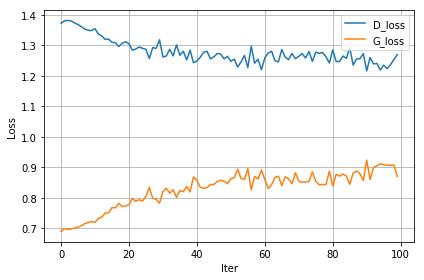

In [18]:
train_C(primaryTrainLoader, embeddingNet, epochs=100, embeddingNetWt=1)

#### Triplet Loss Initialized Embedding Layer E

In [13]:
# we will now be using LeNet instead of embeddingNet
from networks import LeNet, TripletNet

# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
helperDataset = 'SVHN'
numClasses = 10
cuda = 1

# theta and phi are defined based on the number of channels in primary and helper datasets
theta = LeNet(getChannels(primaryDataset))
phi = LeNet(getChannels(helperDataset))

# load the weights of neural networks $\theta$ and $\phi$ saved while training using Siamese and Triplet loss
model = TripletNet(theta, phi)

if cuda:
    model = model.cuda()

modelFoldername = 'models'
modelFileName = primaryDataset+'_'+helperDataset+'_'+'triplet'+'.pt'

PATH = modelFoldername + '/' + modelFileName
model.load_state_dict(torch.load(PATH))

# setting the require_grad as False for all parameters pertaining thera and phi
for param in model.parameters():
    param.require_grad=False

### MNIST 

In [14]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primayTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primayTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

In [15]:
embeddingNet = model.embedding_net_1

/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch : [1/20] time: 13.16, loss_d: 1.294, loss_g: 0.759
Epoch : [2/20] time: 8.01, loss_d: 1.311, loss_g: 0.757
Epoch : [3/20] time: 8.08, loss_d: 1.317, loss_g: 0.755
Epoch : [4/20] time: 8.04, loss_d: 1.326, loss_g: 0.754
Epoch : [5/20] time: 8.03, loss_d: 1.323, loss_g: 0.760
Epoch : [6/20] time: 8.02, loss_d: 1.334, loss_g: 0.752
Epoch : [7/20] time: 8.60, loss_d: 1.334, loss_g: 0.756
Epoch : [8/20] time: 8.09, loss_d: 1.331, loss_g: 0.759
Epoch : [9/20] time: 8.19, loss_d: 1.330, loss_g: 0.758
Epoch : [10/20] time: 8.18, loss_d: 1.328, loss_g: 0.763
Epoch : [11/20] time: 8.16, loss_d: 1.317, loss_g: 0.772
Epoch : [12/20] time: 8.13, loss_d: 1.311, loss_g: 0.780
Epoch : [13/20] time: 8.12, loss_d: 1.284, loss_g: 0.808
Epoch : [14/20] time: 8.15, loss_d: 1.292, loss_g: 0.806
Epoch : [15/20] time: 8.12, loss_d: 1.295, loss_g: 0.811
Epoch : [16/20] time: 8.13, loss_d: 1.274, loss_g: 0.830
Epoch : [17/20] time: 8.15, loss_d: 1.287, loss_g: 0.825
Epoch : [18/20] time: 8.13, loss_d: 1.2

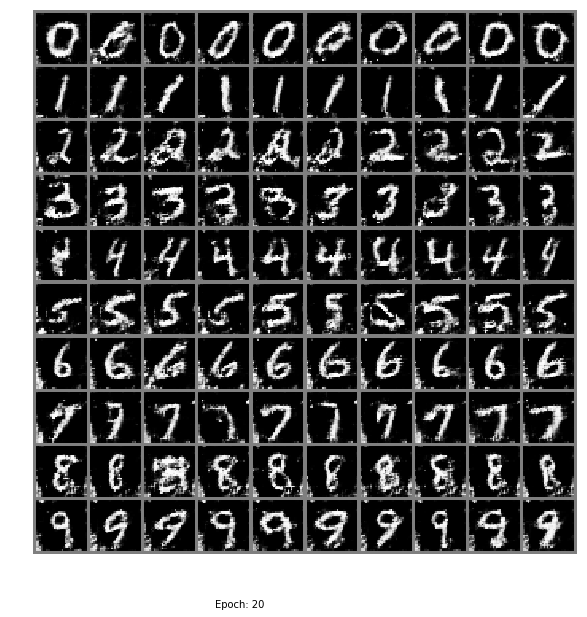

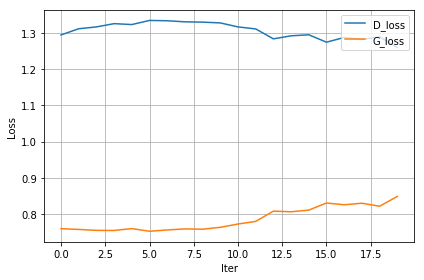

In [16]:
train_C(primaryTrainLoader, embeddingNet,  epochs=20, embeddingNetWt=0)

/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch : [1/20] time: 11.76, loss_d: 1.297, loss_g: 0.755
Epoch : [2/20] time: 7.79, loss_d: 1.269, loss_g: 0.781
Epoch : [3/20] time: 7.80, loss_d: 1.274, loss_g: 0.790
Epoch : [4/20] time: 7.80, loss_d: 1.297, loss_g: 0.784
Epoch : [5/20] time: 7.82, loss_d: 1.315, loss_g: 0.773
Epoch : [6/20] time: 8.28, loss_d: 1.319, loss_g: 0.770
Epoch : [7/20] time: 7.79, loss_d: 1.329, loss_g: 0.764
Epoch : [8/20] time: 7.82, loss_d: 1.328, loss_g: 0.765
Epoch : [9/20] time: 7.83, loss_d: 1.319, loss_g: 0.775
Epoch : [10/20] time: 7.81, loss_d: 1.317, loss_g: 0.775
Epoch : [11/20] time: 7.85, loss_d: 1.293, loss_g: 0.803
Epoch : [12/20] time: 7.95, loss_d: 1.309, loss_g: 0.793
Epoch : [13/20] time: 7.98, loss_d: 1.293, loss_g: 0.810
Epoch : [14/20] time: 8.00, loss_d: 1.293, loss_g: 0.816
Epoch : [15/20] time: 8.05, loss_d: 1.278, loss_g: 0.840
Epoch : [16/20] time: 8.18, loss_d: 1.274, loss_g: 0.832
Epoch : [17/20] time: 7.93, loss_d: 1.255, loss_g: 0.856
Epoch : [18/20] time: 7.94, loss_d: 1.2

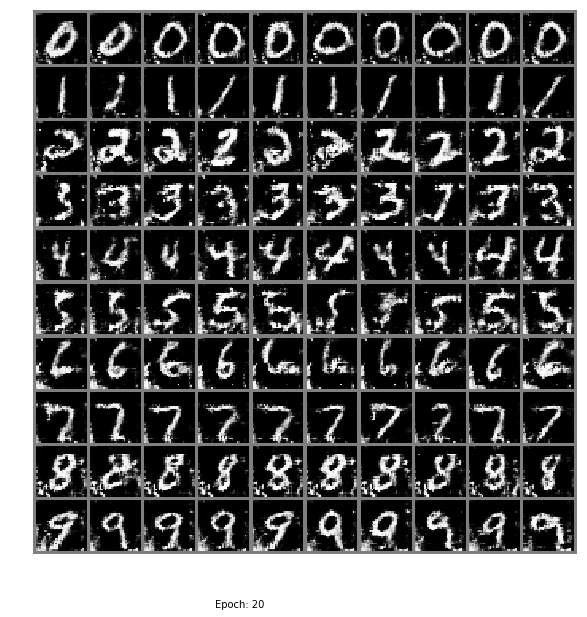

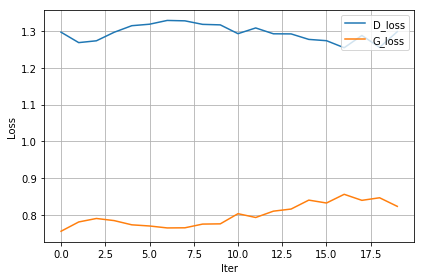

In [23]:
train_C(primaryTrainLoader, embeddingNet =  model.embeddding_layer_1,  epochs=100, embeddingNetWt=0)

#### SVHN

In [17]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'SVHN'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primayTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primayTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

Epoch : [1/20] time: 8.31, loss_d: 1.307, loss_g: 0.755
Epoch : [2/20] time: 8.67, loss_d: 1.249, loss_g: 0.798
Epoch : [3/20] time: 8.21, loss_d: 1.245, loss_g: 0.828
Epoch : [4/20] time: 8.21, loss_d: 1.238, loss_g: 0.846
Epoch : [5/20] time: 8.19, loss_d: 1.182, loss_g: 0.906
Epoch : [6/20] time: 8.20, loss_d: 1.150, loss_g: 0.957
Epoch : [7/20] time: 8.36, loss_d: 1.114, loss_g: 1.016
Epoch : [8/20] time: 8.53, loss_d: 0.961, loss_g: 1.178
Epoch : [9/20] time: 8.43, loss_d: 0.944, loss_g: 1.249
Epoch : [10/20] time: 8.40, loss_d: 1.052, loss_g: 1.166
Epoch : [11/20] time: 8.47, loss_d: 1.004, loss_g: 1.210
Epoch : [12/20] time: 8.48, loss_d: 0.872, loss_g: 1.384
Epoch : [13/20] time: 8.47, loss_d: 0.745, loss_g: 1.575
Epoch : [14/20] time: 8.52, loss_d: 0.665, loss_g: 1.746
Epoch : [15/20] time: 8.49, loss_d: 0.492, loss_g: 2.022
Epoch : [16/20] time: 9.16, loss_d: 0.333, loss_g: 2.414
Epoch : [17/20] time: 8.45, loss_d: 0.197, loss_g: 2.836
Epoch : [18/20] time: 8.48, loss_d: 0.17

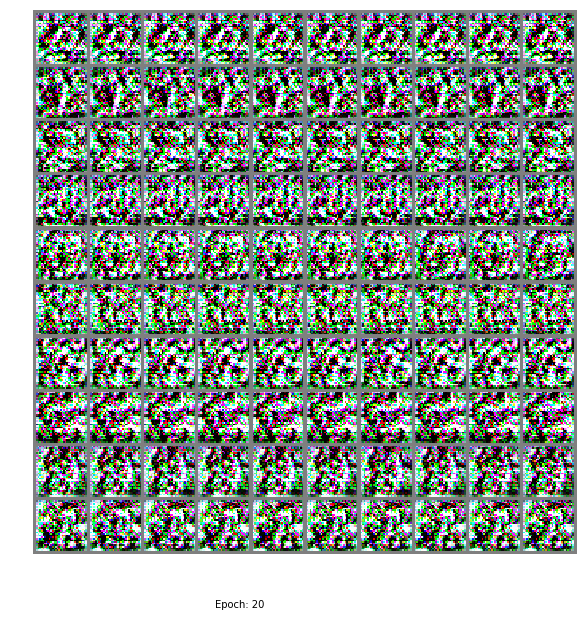

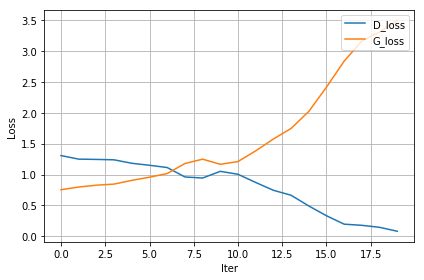

In [21]:
train_C(primaryTrainLoader, model.embedding_net_2,  epochs=20, embeddingNetWt=0)